Lecture 4
===========================================================================

One dimensional unconstrained optimisation
------------

In [39]:
from __future__ import division
from __future__ import print_function

In [40]:
import sympy
sympy.init_printing()

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Bracketing
------------

The goal of bracketing is to find an interval on which a minimum occurs. We search with acceleration, doubling the interval size each time until the function no longer descends.


In [204]:
x = sympy.Symbol('x')
f = (x - 100)**2
xint = [0, 1] # initial interval
delta = 1
k = 1
while f.subs(x, xint[k]) <  f.subs(x, xint[k-1]):
    xint.append(xint[k] + delta*2**k)
    k = k + 1
fs = [f.subs(x, xi) for xi in xint]

In [205]:
from ipywidgets import HTML
def table(values):
    return HTML("<table border='1' cellpadding='10'>{}</table>".format(
             ''.join("<tr>{}</tr>".format( 
             ''.join("<td>{}</td>".format(value) for value in row)) for row in values)))

In [206]:
table(zip(xint, fs))

The minimum must lie between the third last and last x value in the table above.

In [207]:
def zerospines():
    ax = plt.gca()
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

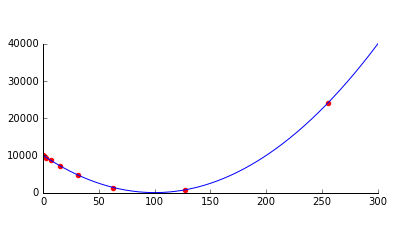

In [209]:
evalfunc = sympy.lambdify(x, f, modules=['numpy'])
xval = np.linspace(0.0, 300.0, 1000)
plt.plot(xval, evalfunc(xval))
plt.scatter(xint, fvals, color='r')
zerospines()
plt.xlim(0, 300)
plt.show()

Newton's Method
------------

In [210]:
x = sympy.Symbol('x')
f = x**4 - x + 1
fd = f.diff(x)
fdd = f.diff(x, 2)
fd, fdd

In [211]:
N = 10
xs = [3.0]
for i in range(N-1): # For convenience we do a fixed number of points
    xs.append(xs[-1] - fd.subs(x, xs[-1])/fdd.subs(x, xs[-1]))
Nfs = [f.subs(x,xi) for xi in xs]
xsN = xs

In [212]:
table(zip(xs, fs))

### How does it work?

Newton's method starts off by using a second order Taylor expansion, this is equivalent to approximating the function with a quadratic polynomial:

In [213]:
def lam(f):
    return sympy.lambdify(x, f, modules=['numpy'])

In [214]:
def second_order_taylor(f, x0):
    return f.series(x, x0=x0, n=3).removeO()

In [215]:
x0 = 3
xvals = np.linspace(-5.0, 5.0, 100)

In [216]:
def plotfunction(f, xvals, formatstring='b'):
    plt.plot(xvals, [f.subs(x, xi) for xi in xvals], formatstring)

In [232]:
def plotpoint(f, xi, color='blue', hline=False, vline=False):
    yi = f.subs(x, xi)
    plt.scatter(xi, yi, color=color)
    if hline:
        plt.axvline(yi, color=color)
    if vline:
        plt.axvline(xi, color=color)

In [233]:
def shownewton(f, x0):
    xvals2 = np.linspace(x0 - 2, x0 + 2, 100)
    quadratic_approx = second_order_taylor(f, x0)
    plotfunction(f, xvals)
    plotfunction(quadratic_approx, xvals2, 'm')
    plotpoint(f, x0, color='m')
    zerospines()

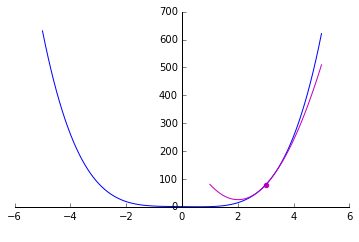

In [234]:
shownewton(f, x0)
plt.show()

Then the derivative of this quadratic function is set to zero, this is equivalent to approximating the true derivative at the point as a straight line and finding its intercept with the x-axis:

In [235]:
def shownewtond(f, x0):
    xvals2 = np.linspace(x0 - 2, x0 + 2, 100)
    fd = f.diff(x)
    quadratic_approx = second_order_taylor(f, x0)
    taylord = quadratic_approx.diff(x)
    intercept = sympy.solve(taylord, x)[0]

    plotfunction(fd, xvals)
    plotfunction(taylord, xvals2, 'r')
    plotpoint(fd, x0)
    plotpoint(fd, intercept, 'g', vline=True)
    plt.xlim(-2,5)
    plt.ylim(-100,300)
    zerospines()

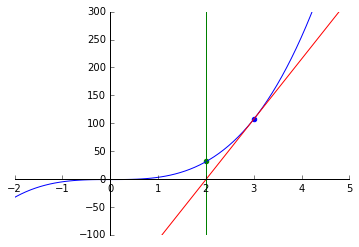

In [240]:
shownewtond(f, 3)
plt.show()

This gives a value of around 2, as indicated in the table above and is also equivalent to jumping to minimum of the previously fitted quadratic. This is used as the new x value to evaluate the slope.

In [241]:
from ipywidgets import interact

In [244]:
def newton_combined(niter=0):
    x0 = float(xsN[niter])
    shownewton(f, x0)
    plt.figure()
    shownewtond(f, x0)
    plt.show()

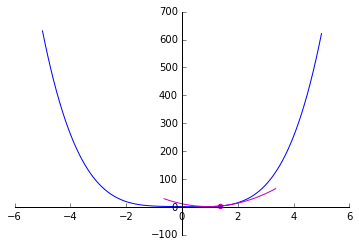

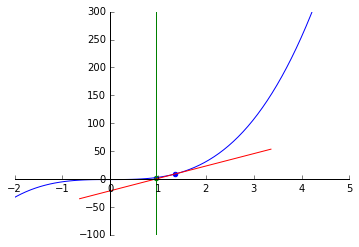

In [245]:
interact(newton_combined, niter=[0, 7])

Quasi-Newton (Secant) method
------------

Note that this variation is a bracketing method, but secant methods do not require the points to span the mnimum in general. The algorithm implemented here is as it is described in the textbook.


In [260]:
# Secant method on this function
N = 10 # iterations
xp = -3.0
xq = 3.0 # initial points
xps = []
xqs = []
xs = []
for i in range(N):
    xps.append(xp)
    xqs.append(xq)
    fxq = fd.subs(x,xq)
    fxp = fd.subs(x,xp)
    xroot = (xq - fxq * (xq - xp) / (fxq - fxp))
    xs.append(xroot)
    froot = fd.subs(x,xroot)
    if sympy.sign(fxp) == sympy.sign(froot):
        xp = xroot
    else:
        xq = xroot

Sfs = [f.subs(x, xi) for xi in xs]
xsS = xs

In [261]:
table(zip(xsS, Sfs))

The method effectively searches for the zero intercept of the derivative as approximated as a straight line between the two chosen points.

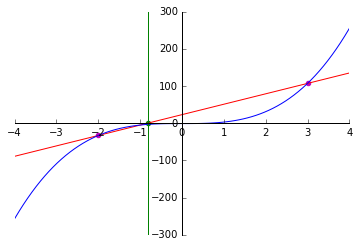

In [255]:
def showsecant(x1, x2):
    y1 = fd.subs(x, x1)
    y2 = fd.subs(x, x2)
    line = (y2 - y1)/(x2 - x1)*(x - x1) + y1

    plotfunction(line, xvals, 'r')
    plotfunction(fd, xvals)
    plotpoint(fd, x1, 'm')
    plotpoint(fd, x2, 'm')
    intercept = sympy.solve(line)[0]
    plotpoint(line, intercept, 'g', vline=True)
    plt.xlim(-4, 4)
    plt.ylim(-300, 300)
    zerospines()
showsecant(-2, 3)
plt.show()

One of the remaining points must be selected in order to calculate the new approximation, this is done by ensuring that the slope has the opposite sign at the two chosen points.

In [266]:
def show_secant(niter=0):
    showsecant(xps[niter], xqs[niter])

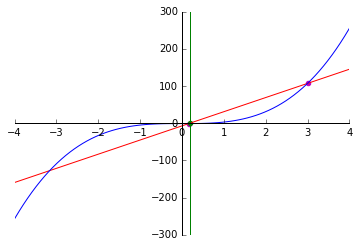

In [269]:
interact(show_secant, niter=[0, 10])

Secant starts better but converges slower for this function. This is in fact a general rule.

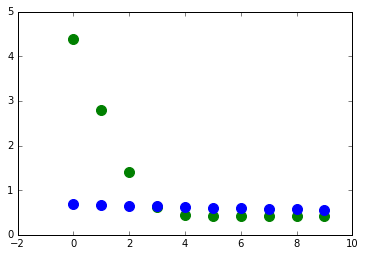

In [271]:
itervals = np.arange(len(Nfs))
Nfsarr = np.asarray(Nfs)
Nfslog = [sympy.log(y+1) for y in Nfsarr]
Sfsarr = np.asarray(Sfs)
Sfslog = [sympy.log(y+1) for y in Sfsarr]
plt.scatter(itervals, Nfslog, s=100, color='g')
plt.scatter(itervals, Sfslog, s=100, color='b')
plt.show()